In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import Dependencies

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
%config InlineBackend.figure_format = 'svg'

# Selecting the folder

In [ ]:
data_dir = '/classification_dataset/'

In [ ]:
train_path = data_dir + 'train/'
test_path = data_dir + 'test/'

In [ ]:
print(os.listdir(train_path))
print(os.listdir(test_path))

['3', '1', '4', '2', '0']
['4', '3', '1', '0', '2']


In [ ]:
imageName = os.listdir(train_path + '0')[0]

'NormalG0 (412).png'

# Viewing an example image of the knee in the dataset

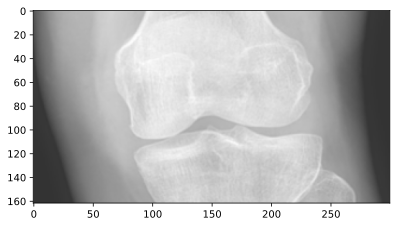

In [ ]:
img = (train_path + '0/' + imageName)
plt.imshow(imread(img), cmap = 'gray')

# Counting the amount of data in each severity level

In [ ]:
# train
for i in os.listdir(train_path):
    print(f'{i}: {len(os.listdir(train_path + i))}')

3: 428
2: 428
1: 383
0: 428
4: 428


In [ ]:
# test
for i in os.listdir(test_path):
    print(f'{i}: {len(os.listdir(test_path + i))}')

4: 71
2: 75
0: 75
3: 75
1: 75


# Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(brightness_range = [0.2, 1.0],
                                rotation_range = 20,
                                rescale = 1 / 255,
                                shear_range = 0.1,
                                zoom_range = 0.1,
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = 'nearest')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization

In [ ]:
BATCH_SIZE = 16
IMG_SHAPE = (160, 335, 1)

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size = IMG_SHAPE[:2],
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical',
                                                shuffle = True)

Found 2140 images belonging to 5 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                                target_size = IMG_SHAPE[:2],
                                                color_mode = 'rgb',
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical',
                                                shuffle = False)

Found 375 images belonging to 5 classes.


In [ ]:
train_image_gen.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

# Creating Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [ ]:
# Early Stop
early_stop = EarlyStopping(monitor='val_accuracy',patience=10, verbose=2, restore_best_weights=True)

In [ ]:
# Checkpoint Saving
saveCheckpointsPath = "/models/XceptionModels/improved-{epoch:02d}-{val_accuracy:.2f}.keras"
Xceptioncheckpoint = ModelCheckpoint(saveCheckpointsPath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

In [ ]:
# Record Accuracy and Loss in a CSV file
logXception = CSVLogger("XceptionLogs.csv", separator = ',', append = False)

# Calculating the class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
y_train = train_image_gen.labels
y_test = test_image_gen.labels

In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 428, 1: 383, 2: 428, 3: 428, 4: 428}
{0: 0.9789719626168224, 1: 1.0939947780678851, 2: 0.9789719626168224, 3: 0.9789719626168224, 4: 0.9789719626168224}


# Xception Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the input shape
input_shape = (160, 335, 3)
inputs = tf.keras.layers.Input(shape=input_shape)

# Load the Xception model with the defined input tensor
XceptionModel = tf.keras.applications.Xception(
    input_tensor=inputs,
    include_top=False,
    weights='imagenet'
)

# Set all layers to be trainable
for layer in XceptionModel.layers:
    layer.trainable = True


X = XceptionModel.output
# custom layers
X = tf.keras.layers.GlobalAveragePooling2D()(X)
X = Dropout(0.2)(X)
predictions = Dense(5, activation='softmax')(X)

Xception_model = Model(inputs=XceptionModel.input, outputs=predictions)

# summary
Xception_model.summary()

# compile
Xception_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

# Model Training

In [ ]:
history = Xception_model.fit(
    train_image_gen,
    epochs=100,
    callbacks=[early_stop, Xceptioncheckpoint, logXception],
    validation_data=test_image_gen,
    class_weight=train_class_weights,
    verbose=1,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4077 - loss: 1.3799
Epoch 1: val_accuracy improved from -inf to 0.29867, saving model to /content/drive/MyDrive/XceptionSavedModels/improved-01-0.30.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.4084 - loss: 1.3788 - val_accuracy: 0.2987 - val_loss: 7.7358
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.5744 - loss: 1.0103
Epoch 2: val_accuracy improved from 0.29867 to 0.37867, saving model to /content/drive/MyDrive/XceptionSavedModels/improved-02-0.38.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 68s 484ms/step - accuracy: 0.5746 - loss: 1.0100 - val_accuracy: 0.3787 - val_loss: 1.8805
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6179 - loss: 0.9294
Epoch 3: val_accuracy improved from 0.37867 to 0.55733, saving model to /content/drive/MyDrive/XceptionSavedModels/improved-03-0.56.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 70s 489ms/step - accuracy: 0.6180 - loss: 0.9292 - val_accuracy: 0.557

# Saving the model

In [ ]:
Xception_model.save('models/XceptionModel.keras')

In [ ]:
Xception_model.metrics_names

['loss', 'compile_metrics']

# Evaluate model with test data

In [ ]:
Xception_model.evaluate(test_image_gen)

24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step - accuracy: 0.5770 - loss: 0.9978


[1.2102304697036743, 0.5525606274604797]

# Visualize the plot of the result

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

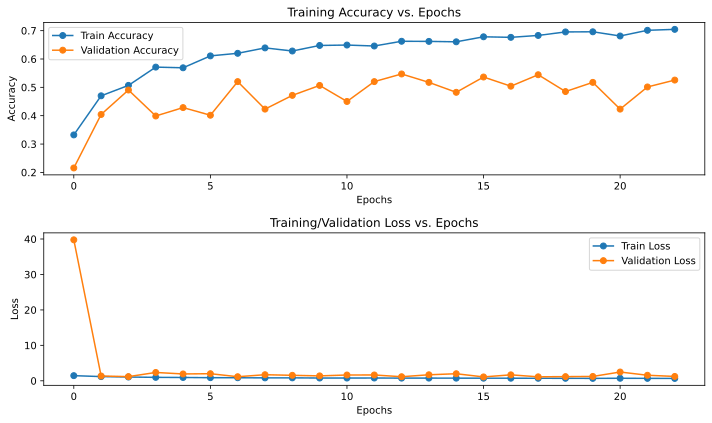

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].set_title('Training/Validation Accuracy vs Epochs')
ax[0].plot(train_accuracy, 'o-', label='Training Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs Epochs')
ax[1].plot(train_loss, 'o-', label='Training Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Loading the last Checkpoint with the best accuracy

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
LoadedModel = load_model('/models/XceptionModels/improved-48-0.84.keras')

# Evaluating the Model Loaded with the Test Data

In [ ]:
LoadedModel.metrics_names

['loss', 'compile_metrics']

In [ ]:
LoadedModel.evaluate(test_image_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 189s 8s/step - accuracy: 0.7974 - loss: 0.6541


[0.7537340521812439, 0.8159999847412109]

# Metrics

In [ ]:
df = pd.read_csv('XceptionLogs.csv')

In [ ]:
train_accuracy = df['accuracy']
val_accuracy = df['val_accuracy']

train_loss = df['loss']
val_loss = df['val_loss']

# Plotting the graphs

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].set_title('Training/Validation Accuracy vs Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.savefig('SavedXception.png')
plt.show()

# Predicting the Test Data and Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
pred = LoadedModel.predict(test_image_gen)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step


In [ ]:
y_pred = np.argmax(pred, axis = 1)
y_test = test_image_gen.classes

In [ ]:
# print classification report
print(classification_report(y_test, y_pred, target_names=labels.values()))

<Axes: >

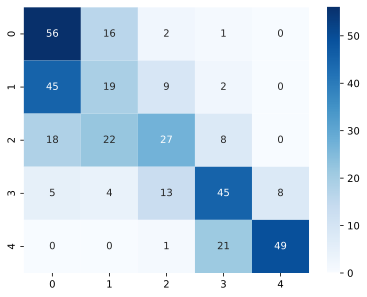

In [ ]:
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, linecolor = 'white', cmap = 'Blues')

# Making inference on unseen values

In [ ]:
import cv2

In [ ]:
dictionary = {
    0 : "Normal",
    1 : "Doubtful",
    2 : "Mild",
    3 : "Moderate",
    4 : "Severe",
}

In [ ]:
def CheckSeverity(img):
    resize = tf.image.resize(img, (160, 335))
    plt.imshow(resize.numpy().astype(int))
    plt.show()

    prediction = LoadedModel.predict(np.expand_dims(resize / 255, 0))
    prediction = np.argmax(prediction, axis = 1)
    if prediction[0] in dictionary:
        print(dictionary[prediction[0]])

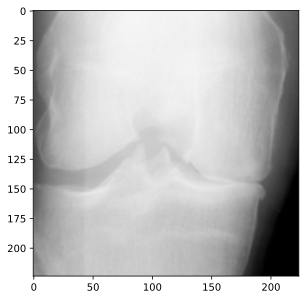

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Severe


In [ ]:
img = cv2.imread('/classification_dataset/test/4/9012867R.png')
CheckSeverity(img)